In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Fri Jan 12 00:12:05 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   25C    P8    14W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-2/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 345608
-rw-rw-r-- 1 scpark scpark  1056548  1월 12 00:12 events.out.tfevents.1704985368.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37979741  1월 12 00:10 save_10000
-rw-rw-r-- 1 scpark scpark 37973949  1월 12 00:02 save_0
-rw-rw-r-- 1 scpark scpark   907076  1월 12 00:02 events.out.tfevents.1704984907.GPUSVR01
-rw-rw-r-- 1 scpark scpark   357284  1월 11 23:55 events.out.tfevents.1704984718.GPUSVR01
-rw-rw-r-- 1 scpark scpark  1077860  1월 11 22:02 events.out.tfevents.1704977575.GPUSVR01
-rw-rw-r-- 1 scpark scpark   906116  1월 11 21:52 events.out.tfevents.1704977086.GPUSVR01
-rw-rw-r-- 1 scpark scpark  5431982  1월 11 21:44 events.out.tfevents.1704974487.GPUSVR01
-rw-rw-r-- 1 scpark scpark 66192541  1월 11 21:39 save_50000
-rw-rw-r-- 1 scpark scpark 66192541  1월 11 21:31 save_40000
-rw-rw-r-- 1 scpark scpark 66192541  1월 11 21:24 save_30000
-rw-rw-r-- 1 scpark scpark 66192541  1월 11 21:16 save_20000
-rw-rw-r-- 1 scpark scpark   463076  1월 11 21:01 events.out.tfevents.1704974252.GPUSVR01
-rw-rw-r

### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


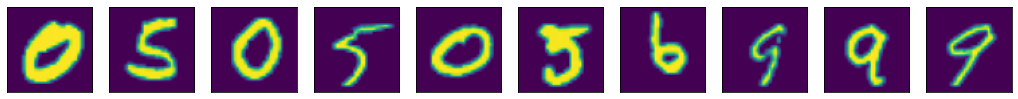

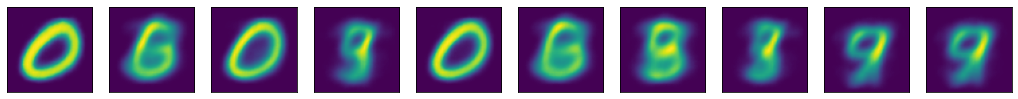

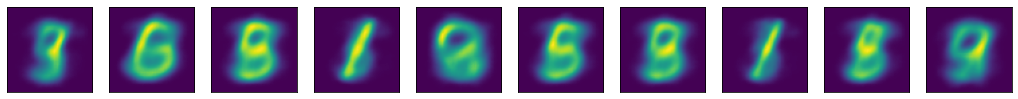

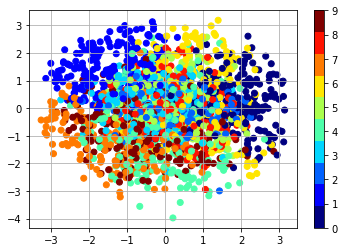

49001
lse_loss 2.45330548286438
recon_loss 0.16814297437667847
49002
lse_loss 2.5985708236694336
recon_loss 0.16565367579460144
49003
lse_loss 2.3456389904022217
recon_loss 0.1545143574476242
49004
lse_loss 2.630830764770508
recon_loss 0.17187683284282684
49005
lse_loss 2.2906436920166016
recon_loss 0.16643193364143372
49006
lse_loss 2.4736101627349854
recon_loss 0.17428511381149292
49007
lse_loss 2.3177285194396973
recon_loss 0.17152690887451172
49008
lse_loss 2.813210964202881
recon_loss 0.16662368178367615
49009
lse_loss 2.2477195262908936
recon_loss 0.1670084446668625
49010
lse_loss 2.590620517730713
recon_loss 0.16860316693782806
49011
lse_loss 2.6809699535369873
recon_loss 0.16582538187503815
49012
lse_loss 2.374746799468994
recon_loss 0.17251241207122803
49013
lse_loss 2.5079100131988525
recon_loss 0.16811394691467285
49014
lse_loss 2.4450178146362305
recon_loss 0.1716051995754242
49015
lse_loss 2.204801559448242
recon_loss 0.173826664686203
49016
lse_loss 2.688953399658203
reco

49130
lse_loss 2.645198106765747
recon_loss 0.16996726393699646
49131
lse_loss 2.865420341491699
recon_loss 0.16663621366024017
49132
lse_loss 2.642608880996704
recon_loss 0.16408085823059082
49133
lse_loss 2.858548641204834
recon_loss 0.1624404788017273
49134
lse_loss 2.6091744899749756
recon_loss 0.16399788856506348
49135
lse_loss 2.511139154434204
recon_loss 0.16543523967266083
49136
lse_loss 2.410766839981079
recon_loss 0.1644657850265503
49137
lse_loss 2.304021120071411
recon_loss 0.17650505900382996
49138
lse_loss 2.4566941261291504
recon_loss 0.17341211438179016
49139
lse_loss 2.772064447402954
recon_loss 0.1738879680633545
49140
lse_loss 2.4807140827178955
recon_loss 0.18155160546302795
49141
lse_loss 2.6987390518188477
recon_loss 0.16037052869796753
49142
lse_loss 2.26771879196167
recon_loss 0.17102980613708496
49143
lse_loss 2.4612972736358643
recon_loss 0.16349872946739197
49144
lse_loss 2.542527198791504
recon_loss 0.17624863982200623
49145
lse_loss 2.3155570030212402
recon

49260
lse_loss 2.395338773727417
recon_loss 0.1719520539045334
49261
lse_loss 2.405128002166748
recon_loss 0.17131531238555908
49262
lse_loss 2.522825002670288
recon_loss 0.17438265681266785
49263
lse_loss 2.493342161178589
recon_loss 0.17065738141536713
49264
lse_loss 2.71543550491333
recon_loss 0.17936265468597412
49265
lse_loss 2.6541144847869873
recon_loss 0.16953560709953308
49266
lse_loss 2.3290858268737793
recon_loss 0.17960894107818604
49267
lse_loss 2.340710163116455
recon_loss 0.18254303932189941
49268
lse_loss 2.40614652633667
recon_loss 0.1694556176662445
49269
lse_loss 2.470412015914917
recon_loss 0.1742592304944992
49270
lse_loss 2.4788308143615723
recon_loss 0.16854515671730042
49271
lse_loss 2.317340135574341
recon_loss 0.17810878157615662
49272
lse_loss 2.824981451034546
recon_loss 0.17555181682109833
49273
lse_loss 2.2382941246032715
recon_loss 0.16995736956596375
49274
lse_loss 2.384145736694336
recon_loss 0.1767951250076294
49275
lse_loss 2.7874844074249268
recon_lo

49390
lse_loss 2.4364802837371826
recon_loss 0.18413595855236053
49391
lse_loss 2.806562900543213
recon_loss 0.18476593494415283
49392
lse_loss 2.290475845336914
recon_loss 0.17117881774902344
49393
lse_loss 2.4582061767578125
recon_loss 0.16740255057811737
49394
lse_loss 2.2932674884796143
recon_loss 0.16971731185913086
49395
lse_loss 2.350914716720581
recon_loss 0.16227909922599792
49396
lse_loss 2.315857410430908
recon_loss 0.16929039359092712
49397
lse_loss 2.450136184692383
recon_loss 0.1705513894557953
49398
lse_loss 2.6308391094207764
recon_loss 0.17130741477012634
49399
lse_loss 2.815969944000244
recon_loss 0.17316144704818726
49400
lse_loss 2.6931889057159424
recon_loss 0.1808183789253235
49401
lse_loss 2.3815553188323975
recon_loss 0.17453885078430176
49402
lse_loss 2.501464605331421
recon_loss 0.1703474521636963
49403
lse_loss 2.4303066730499268
recon_loss 0.16464830935001373
49404
lse_loss 2.3086869716644287
recon_loss 0.17394986748695374
49405
lse_loss 2.4697539806365967
r

49518
lse_loss 2.3551905155181885
recon_loss 0.1745058298110962
49519
lse_loss 2.526360034942627
recon_loss 0.1812114715576172
49520
lse_loss 2.203714370727539
recon_loss 0.17783281207084656
49521
lse_loss 2.8257553577423096
recon_loss 0.1789560765028
49522
lse_loss 2.2907443046569824
recon_loss 0.1828298568725586
49523
lse_loss 2.782256603240967
recon_loss 0.17118152976036072
49524
lse_loss 2.249896287918091
recon_loss 0.1683589220046997
49525
lse_loss 2.6065633296966553
recon_loss 0.17877835035324097
49526
lse_loss 2.605302572250366
recon_loss 0.1716046780347824
49527
lse_loss 2.489610433578491
recon_loss 0.1649344563484192
49528
lse_loss 2.449138641357422
recon_loss 0.18138417601585388
49529
lse_loss 2.587820529937744
recon_loss 0.16799239814281464
49530
lse_loss 2.651093006134033
recon_loss 0.16455227136611938
49531
lse_loss 2.9799506664276123
recon_loss 0.18837597966194153
49532
lse_loss 2.2895455360412598
recon_loss 0.16712288558483124
49533
lse_loss 2.6775240898132324
recon_loss

lse_loss 2.666382074356079
recon_loss 0.17251136898994446
49647
lse_loss 2.4227330684661865
recon_loss 0.16981440782546997
49648
lse_loss 2.47182559967041
recon_loss 0.17512917518615723
49649
lse_loss 2.7471213340759277
recon_loss 0.16417881846427917
49650
lse_loss 2.393164873123169
recon_loss 0.169531911611557
49651
lse_loss 2.397383451461792
recon_loss 0.18061679601669312
49652
lse_loss 2.6058349609375
recon_loss 0.16714125871658325
49653
lse_loss 2.2844948768615723
recon_loss 0.17163167893886566
49654
lse_loss 2.4296252727508545
recon_loss 0.1696033477783203
49655
lse_loss 2.183887004852295
recon_loss 0.1734461486339569
49656
lse_loss 2.3248941898345947
recon_loss 0.17057907581329346
49657
lse_loss 2.4422109127044678
recon_loss 0.16811101138591766
49658
lse_loss 2.735538959503174
recon_loss 0.17262010276317596
49659
lse_loss 2.3664348125457764
recon_loss 0.1711859405040741
49660
lse_loss 2.4150941371917725
recon_loss 0.17171773314476013
49661
lse_loss 2.606154203414917
recon_loss 0.

KeyboardInterrupt: 

In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=10000, sigma=1e-1)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000, sigma=1e-1)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        